In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import pickle
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import math
from time import time
from underthesea import word_tokenize
from operator import itemgetter
import warnings
import jieba
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('2k_data_Sep.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Feedback ID      2000 non-null   float64
 1   Lookup Text      2000 non-null   object 
 2   Question Text    2000 non-null   object 
 3   Feedback Type    2000 non-null   object 
 4   Feedback Result  2000 non-null   object 
 5   Human Feedback   2000 non-null   object 
 6   Lookup Image     2000 non-null   object 
 7   Question Image   2000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 125.1+ KB


In [3]:
def clean_function(text):  
    #lowercase
    text = text.lower()
    
#     #xoá ký tự đặc biệt, ký tự không phải alphanumeric 
#     text = re.sub("[^a-z0-9àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",' ', text)
    
#     #xoá leading zero
#     text = [e.lstrip('0') for e in text.split(' ')]
#     text = (' ').join(text)
    
    #replace extra spaces with single space
    text = re.sub(' +',' ',text)
    
#     #xoá khoảng trắng ở đầu và cuối mỗi câu
#     text = text.strip()
    
    #word tokenzie
    text = word_tokenize(text, format='text')
    return text

In [4]:
df['index_org'] = df.index

df['clean_lookup'] = df['Lookup Text'].map(lambda x: clean_function(x))
df['clean_question'] = df['Question Text'].map(lambda x: clean_function(x))

df['char_count_lookup'] = df['clean_lookup'].str.len()
df['word_count_lookup'] = df['clean_lookup'].str.split().str.len()
df['average_word_length_lookup'] = df['char_count_lookup'] / df['word_count_lookup']

df['char_count_question'] = df['clean_question'].str.len()
df['word_count_question'] = df['clean_question'].str.split().str.len()
df['average_word_length_question'] = df['char_count_question'] / df['word_count_question']

In [5]:
check_dup = df[['Lookup Text', 'Question Text']][df[['Lookup Text', 'Question Text']].duplicated()]
df = df.drop(check_dup.index)
df = df.reset_index(drop = True)
df.shape

(1962, 17)

In [6]:
mask1 = df['Human Feedback'] == 'MATCH'

df_pos = df[mask1].reset_index(drop = True)
df_pos

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question
0,4419.0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0398020...,https://s3.icankid.io/uploads/question/5a47b89...,1,đề số \ ( 1_._\ ) 1_._tính b ) \ ( \ sqrt { 25...,b ) \ ( \ sqrt { 25 }_\ ) c ) \ ( \ sqrt { - 3...,395,130,3.038462,400,131,3.053435
1,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...,2,1_._tính : \ ( \ sqrt {_\ frac { 25 }_{ 4 } }_...,đề số \ ( 3 . \ ) 1_._tính : \ ( \ sqrt {_\ fr...,230,73,3.150685,248,81,3.061728
2,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/71b3a3c...,https://s3.icankid.io/uploads/question/3c3ec9e...,7,25 . tìm giá_trị x ( làm tròn đến chữ_số thập_...,b ) canh bc . 5 . tìm giá_trị \ ( x \ ) ( làm ...,146,31,4.709677,160,41,3.902439
3,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/690df82...,https://s3.icankid.io/uploads/question/44a094e...,11,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,219,72,3.041667,218,72,3.027778
4,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/539c341...,https://s3.icankid.io/uploads/question/eb404dc...,13,câu 7 . các giá_trị của \ ( x \ ) thỏa mã \ ( ...,câu 7 . các giá_trị của \ ( x \ ) thỏa_mãn \ (...,425,152,2.796053,426,151,2.821192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,9955.0,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a08206d...,https://s3.stag.icankids.com.vn/uploads/questi...,1989,3.36 . cho biết tích của hai số tự_nhiên \ ( n...,3.36 . cho biết tích của hai số tự_nhiên \ ( n...,148,49,3.020408,156,52,3.000000
992,9967.0,"Câu 10: Trong hệ trục Oxy, cho \( \vec{u}=(-2 ...","Câu 18: Trong mặt phẳng tọa độ \( O x y \), ch...",NEGATIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/d34ea5b...,https://s3.icankid.io/uploads/question/d44ded4...,1992,"câu 10 : trong hệ trục oxy , cho \ ( \ vec {_u...",câu 18 : trong mặt_phẳng tọa_độ \ ( o x y \ ) ...,231,99,2.333333,242,99,2.444444
993,9973.0,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/f60a06b...,https://s3.icankid.io/uploads/question/2740c6d...,1994,6 . hai đoạn ống nước có chiều dài lần_lượt là...,6 . hai đoạn ống nước có chiều dài lần_lượt là...,246,65,3.784615,243,64,3.796875
994,9978.0,"bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...","8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...",POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/9fee271...,https://s3.icankid.io/uploads/question/9363c3c...,1995,"bao_nhiêu phần kế_hoạch ? 8 . vào tháng 6 , gi...","8 . vào tháng 6 , giá niêm_yết một chiếc ti vi...",401,90,4.455556,375,86,4.360465


In [7]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    vn_stop_words = file.read()
vn_stop_words = vn_stop_words.split('\n') 

# combine Vietnamese stopwords and English stopwords
stop_words = ENGLISH_STOP_WORDS.union(vn_stop_words)

In [8]:
questions_ = [[text for text in x.split()] for x in df_pos['clean_question']]

In [9]:
questions_ = [[t for t in text if not t in stop_words] for text in questions_] 

In [10]:
dictionary = corpora.Dictionary(questions_)

In [11]:
corpus = [dictionary.doc2bow(quest) for quest in questions_]

In [12]:
questions_tfidf_model = models.TfidfModel(corpus, id2word=dictionary)
questions_lsi_model = models.LsiModel(questions_tfidf_model[corpus], id2word=dictionary, num_topics=100)

In [13]:
corpora.MmCorpus.serialize('question_tfidf_model_mm', questions_tfidf_model[corpus])
corpora.MmCorpus.serialize('question_lsi_model_mm', questions_lsi_model[questions_tfidf_model[corpus]])

In [14]:
questions_tfidf_corpus = corpora.MmCorpus('question_tfidf_model_mm')
questions_lsi_corpus = corpora.MmCorpus('question_lsi_model_mm')

print(questions_tfidf_corpus)
print(questions_lsi_corpus)

MmCorpus(996 documents, 3823 features, 29127 non-zero entries)
MmCorpus(996 documents, 100 features, 99600 non-zero entries)


In [15]:
questions_index = similarities.MatrixSimilarity(questions_lsi_corpus, num_features = questions_lsi_corpus.num_terms)

In [16]:
def gensim_search(query, dictionary, similarities_matrix, questions_tfidf_model, questions_lsi_model, check_time = True):
    t0 = time()
    q = clean_function(query).split()
    query_bow = dictionary.doc2bow(q)
    query_tfidf = questions_tfidf_model[query_bow]
    query_lsi = questions_lsi_model[query_tfidf]

    similarities_matrix.num_best = 5
    questions_list = similarities_matrix[query_lsi]

    questions_list.sort(key=itemgetter(1), reverse=True)
    questions_text = []
#     product = pd.read_csv('data/product_names_clean.csv', index_col=0)

    for j, name in enumerate(questions_list):
        questions_text.append(
            {'lookup_text': query * 5,
             'question_text': df_pos['Question Text'][name[0]],
             'gensim_score': round((name[1] * 100),2),
             'gs_word_count_question': df_pos['word_count_question'][name[0]]})
        if j == (similarities_matrix.num_best-1):
            break
    results = pd.DataFrame(questions_text, columns=['lookup_text', 'question_text','gensim_score', 'gs_word_count_question'])
    if check_time:
        print('Time:', time()-t0)
    return results

In [17]:
gensim_search(df_pos.iloc[0]['Lookup Text'], dictionary=dictionary, similarities_matrix=questions_index,
              questions_tfidf_model=questions_tfidf_model, questions_lsi_model=questions_lsi_model)

Time: 0.017276763916015625


,lookup_text,question_text,gensim_score,gs_word_count_question
0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,93.42,131
1,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,71. Rút gọn các biểu thức sau :\na) \( (\sqrt{...,87.13,190
2,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,Bài 9: Tính\na) \( (\sqrt{5})^{2} \)\nb) \( (\...,86.62,72
3,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,"a) \( \sqrt{0,09} \)\nb) \( \sqrt{-16} \)\nc) ...",86.33,92
4,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,"Bài 2. (3,0 điểm) Thực hiện phép tính:\na \( \...",86.10,98


In [18]:
def gensim_search_all(queries, dictionary, similarities_matrix, questions_tfidf_model, questions_lsi_model, check_time = True):
    t0 = time()
    df_final = pd.DataFrame(columns = ['lookup_text', 'question_text', 'gensim_score', 'gs_word_count_question'])
    for query in queries:
        q = clean_function(query).split()
        query_bow = dictionary.doc2bow(q)
        query_tfidf = questions_tfidf_model[query_bow]
        query_lsi = questions_lsi_model[query_tfidf]

        similarities_matrix.num_best = 5
        questions_list = similarities_matrix[query_lsi]

        questions_list.sort(key=itemgetter(1), reverse=True)
        questions_text = []

        for j, name in enumerate(questions_list):
            questions_text.append(
                {'lookup_text': query * 5,
                 'question_text': df_pos['Question Text'][name[0]],
                 'gensim_score': round((name[1] * 100),2),
                 'gs_word_count_question': df_pos['word_count_question'][name[0]]})
            if j == (similarities_matrix.num_best-1):
                break
        result =  pd.DataFrame(questions_text, columns=['lookup_text', 'question_text','gensim_score', 'gs_word_count_question']).head(1)
        df_final = pd.concat([df_final, result])
    if check_time:
        print('Time:', time()-t0)
    return df_final

In [19]:
result_all = gensim_search_all(df_pos['Lookup Text'], dictionary=dictionary, similarities_matrix=questions_index,
                          questions_tfidf_model=questions_tfidf_model, questions_lsi_model=questions_lsi_model)

Time: 8.030739068984985


In [20]:
result_all = result_all.reset_index(drop = True)
result_all

,lookup_text,question_text,gensim_score,gs_word_count_question
0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,93.42,131
1,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,99.87,81
2,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,63.0,41
3,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,99.92,72
4,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,99.95,151
...,...,...,...,...
991,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,100.0,52
992,"Câu 10: Trong hệ trục Oxy, cho \( \vec{u}=(-2 ...","Câu 18: Trong mặt phẳng tọa độ \( O x y \), ch...",93.11,99
993,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,99.59,64
994,"bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...","8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...",99.97,86


In [21]:
df_pos['search_result'] = result_all['question_text']
df_pos['gensim_score'] = result_all['gensim_score']
df_pos['gs_word_count_question'] = result_all['gs_word_count_question']

In [22]:
# df_pos = df_pos[['Feedback ID', 'Lookup Text', 'Question Text', 
#                  'search_result', 'gensim_score', 'Feedback Type', 'Human Feedback',
#                  'Lookup Image', 'Question Image', 'clean_question']]

In [23]:
df_pos.head()

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question,search_result,gensim_score,gs_word_count_question
0,4419.0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0398020...,https://s3.icankid.io/uploads/question/5a47b89...,1,đề số \ ( 1_._\ ) 1_._tính b ) \ ( \ sqrt { 25...,b ) \ ( \ sqrt { 25 }_\ ) c ) \ ( \ sqrt { - 3...,395,130,3.038462,400,131,3.053435,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,93.42,131
1,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...,2,1_._tính : \ ( \ sqrt {_\ frac { 25 }_{ 4 } }_...,đề số \ ( 3 . \ ) 1_._tính : \ ( \ sqrt {_\ fr...,230,73,3.150685,248,81,3.061728,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,99.87,81
2,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/71b3a3c...,https://s3.icankid.io/uploads/question/3c3ec9e...,7,25 . tìm giá_trị x ( làm tròn đến chữ_số thập_...,b ) canh bc . 5 . tìm giá_trị \ ( x \ ) ( làm ...,146,31,4.709677,160,41,3.902439,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,63.0,41
3,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/690df82...,https://s3.icankid.io/uploads/question/44a094e...,11,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,219,72,3.041667,218,72,3.027778,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,99.92,72
4,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/539c341...,https://s3.icankid.io/uploads/question/eb404dc...,13,câu 7 . các giá_trị của \ ( x \ ) thỏa mã \ ( ...,câu 7 . các giá_trị của \ ( x \ ) thỏa_mãn \ (...,425,152,2.796053,426,151,2.821192,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,99.95,151


In [24]:
mask2 = df_pos['Question Text'] != df_pos['search_result']

df_check = df_pos[mask2]
df_check.shape

(71, 20)

In [25]:
def check_wrong_results(indices):
    index_ = df_check.index.tolist()
    no_results = []
    top5_results = []
    for num in indices:
        df_results = gensim_search(df_check.iloc[num]['Lookup Text'], dictionary=dictionary, similarities_matrix=questions_index,
              questions_tfidf_model=questions_tfidf_model, questions_lsi_model=questions_lsi_model, check_time = False)
        top_results = df_results['question_text'].values
        if (df_check.iloc[num]['Lookup Text'] in top_results) or (df_check.iloc[num]['Question Text'] in top_results):
            top5_results.append(index_[num])
        else:
            no_results.append(index_[num])
    return top5_results, no_results

In [26]:
top5_result, no_result = check_wrong_results(list(range(0, len(df_check.index))))

In [27]:
print(len(top5_result))
print(len(no_result))

52
19


In [28]:
df_no = df_pos.iloc[no_result, :]
df_no

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question,search_result,gensim_score,gs_word_count_question
20,4533.0,Quan sat hai thanh sau:\na) So 0 có phải la bo...,2. Quan sát hai thanh sau:\n\begin{tabular}{|c...,NEGATIVE,NOT_MATCH,MATCH,https://s3.icankid.io/uploads/question/4d68455...,https://s3.icankid.io/uploads/question/a7ce2dd...,45,quan sat hai thanh sau : a ) so 0 có phải la b...,2 . quan_sát hai thanh sau : \ begin { tabular...,233,61,3.819672,361,105,3.438095,1. Các số \( 4 ; 8 ; 9 ; 16 ; 27 ; 64 ; 81 ; 1...,44.53,195
42,4612.0,Câu \( 2 . \)\na) Tim tập hơp các ước cuaa 30 ...,2. a) Tìm tập hợp các ước của 30 .\nb) Tìm tập...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0de11fb...,https://s3.stag.icankids.com.vn/uploads/questi...,79,câu \ ( 2_._\ ) a ) tim tập hơp các ước cuaa 3...,2 ._a ) tìm tập_hợp các ước của 30 ._b ) tìm t...,98,28,3.500000,189,57,3.315789,1.2. Cho tập hợp\n\[\nU=\{x \in N \mid \underl...,59.25,55
131,5123.0,Cov M Ha tḥp hop các só tư nhiên lón hơn 6 và ...,Luyẹ tạp 3\nGọi \( M \) là tập hợ các số tự nh...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/8a2684f...,https://s3.icankid.io/uploads/question/b89da74...,241,cov m ha tḥp hop các só tư_nhiên lón hơn 6 và ...,luyẹ tạp 3 gọi \ ( m \ ) là tập hợ các số tự_n...,95,24,3.958333,201,68,2.955882,Câu 551. Tìm tất cả các giá trị của tham số \(...,81.28,100
225,5626.0,khi hiem.\na) Khí hiếm náo có điêm đông đạc nh...,1.13. Bảng sau cho biết các điểm đông đặc và đ...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/4be5940...,https://s3.icankid.io/uploads/question/da73543...,434,khi hiem ._a ) khí_hiếm náo có điêm đông đạc n...,1.13 . bảng sau cho biết các điểm đông_đặc và ...,264,61,4.327869,1003,241,4.161826,3. Bảng sau cho biết các điểm đông đặc và điểm...,83.82,71
248,5711.0,"""Yêu nhau cau sáu bổ ba Ghét nhau cau sáu bổ r...","Bài 30\n(Toán cổ) Yêu nhau cau sảu bồ ba,\nGhè...",NEGATIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/4cc3eda...,https://s3.icankid.io/uploads/question/4df1230...,463,""" yêu nhau cau sáu bổ ba ghét nhau cau sáu bổ ...","bài 30 ( toán cổ ) yêu nhau cau sảu bồ ba , gh...",126,32,3.937500,148,39,3.794872,"Ví dụ 2. Sử dụng thuật ngữ ""điều kiện cần"", ""đ...",67.49,58
259,5752.0,3. Hoàn thành bảng dưới đây vào vờ (theo mẫu).,3. Hoàn thành bàng dưới đây vào vỡ (theo mảu)....,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/ac82322...,https://s3.icankid.io/uploads/question/f9af365...,480,3 . hoàn_thành bảng dưới đây vào vờ ( theo mẫu...,3 . hoàn_thành bàng dưới đây vào vỡ ( theo mảu...,50,13,3.846154,146,37,3.945946,3. Biểu diễn các số \( 1983 ; 2756 ; 2023 \) t...,52.36,37
311,6037.0,4. Vê một đọan cuia trục số từ -10 đến 10. Biề...,4. Vẽ một đoạn của trục số từ -10 đến 10. Biểu...,NEGATIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/d128527...,https://s3.stag.icankids.com.vn/uploads/questi...,581,4 . vê một đọan cuia trục số từ - 10 đến 10 . ...,4 . vẽ một đoạn của trục số từ - 10 đến 10 . b...,189,54,3.500000,203,67,3.029851,4. Vê một đoạn cúa trục số từ -10 đến 10. Biều...,97.14,55
336,6178.0,1.31. Tinh nhảm bằng cách thềm vào số hạng này...,1.32. Tính nhẩm bằng cách thêm (hoặc bớt) số b...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/bcad509...,https://s3.icankid.io/uploads/question/0b330b4...,632,1.31 . tinh nhảm bằng cách thềm vào số_hạng nà...,1.32 . tính_nhẩm bằng cách thêm ( hoặc bớt ) s...,508,166,3.060241,242,79,3.063291,2. Có thể tính nhầm tồng bằng cách tách một số...,64.63,91
342,6192.0,1.11. Diân só hoăc dáu thich hep vào o tróng:,1.11. Điền số hoặc dấu thích hợp vào ô trống:,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/78b51a7...,https://s3.icankid.io/uploads/question/2958e6c...,640,1.11 ._diân

In [29]:
df_top5 = df_pos.iloc[top5_result, :]
df_top5

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question,search_result,gensim_score,gs_word_count_question
43,4615.0,1.4. Phát biểu mệnh đề đảo của mồi mệnh đề sau...,4. Phát biều mệnh đề đảo của mởi mệnh đề sau v...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/048f21c...,https://s3.icankid.io/uploads/question/2a5256c...,80,1.4 . phát_biểu mệnh_đề đảo của mồi mệnh_đề sa...,4 ._phát biều mệnh_đề đảo của mởi mệnh_đề sau ...,276,73,3.780822,283,78,3.628205,1.4. Phát biểu mệnh đề đảo của mỗi mệnh đề sau...,98.82,78
69,4779.0,Bài 2: Tìm giả trị của a để ba đường thẳng :\n...,Bài 10 Tìm giá trị của a để ba đường thẳng : \...,NEGATIVE,NOT_MATCH,MATCH,https://s3.icankid.io/uploads/question/64277c8...,https://s3.icankid.io/uploads/question/65a2aad...,132,bài 2 : tìm giả trị của a để ba đường_thẳng : ...,bài 10 tìm giá_trị của a để ba đường_thẳng : \...,272,60,4.533333,228,53,4.301887,Câu 1 (TH): Nghiệm của hệ phương trình \( \lef...,67.56,185
103,4970.0,BAI TAPP\n1.1. Cho hai tập hợp:\n\[\nA =\{a ; ...,1.1. Cho hai tập họp:\n\[\nA =\{a ; b ; c ; x ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/d0db61c...,https://s3.icankid.io/uploads/question/48867c2...,196,bai tapp 1.1 . cho hai tập_hợp : \_[_a_=_\_{_a...,1.1 . cho hai tập họp : \_[_a_=_\_{_a ; b ; c ...,272,78,3.487179,270,83,3.253012,1.1. Cho hai tập hợp:\n\[\nA =\{a ; b ; c ; x ...,99.56,79
133,5132.0,1.1. Cho hai têp hơp:\n\[\nA=\{a ; b ; c ; x ;...,1.1. Cho hai tập hợp:\n\[\nA =\{a ; b ; c ; x ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/2833274...,https://s3.icankid.io/uploads/question/4756d5c...,245,1.1 . cho hai têp hơp : \_[_a_=_\_{_a ; b ; c ...,1.1 . cho hai tập_hợp : \_[_a_=_\_{_a ; b ; c ...,276,81,3.407407,276,79,3.493671,1.1. Cho hai tập họp:\n\[\nA =\{a ; b ; c ; x ...,99.11,83
136,5135.0,"1.2. Cho tập hợp\nTrong các số 3; 5; 6; 0;7, s...",1.2. Cho tập họp \( U=\{x \in N \mid x \) chia...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/8586a4c...,https://s3.icankid.io/uploads/question/8d522ad...,248,1.2 . cho tập_hợp trong các số 3 ; 5 ; 6 ; 0 ;...,1.2 . cho tập họp \ ( u =_\_{ x \ in n \ mid x...,124,33,3.757576,155,48,3.229167,1.2. Cho tập hợp\n\( U=\{x \in N \mid x \) chi...,84.91,53
231,5642.0,Bài 5 : Tìm giá trị nhỏ nhất của \( B _{5}=| x...,5. Ví dụ 5 : Tìm giá trị nhỏ nhất của \( B_{6}...,NEGATIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/a54102b...,https://s3.icankid.io/uploads/question/a5e8b46...,442,bài 5 : tìm giá_trị nhỏ nhất của \ ( b _ { 5 }...,5 . ví_dụ 5 : tìm giá_trị nhỏ nhất của \ ( b_ ...,77,26,2.961538,80,23,3.478261,"Bài 1. Tìm \( x, y \) thoả mãn\na) \( |2 x+4|+...",81.95,49
241,5693.0,\( U=\{x \in N \mid x \) chia hết cho 3\( \} \...,1.2. Cho tập hợp\n\( U=\{x \in N \mid x \) chi...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/91aedca...,https://s3.icankid.io/uploads/question/3d2ac53...,456,\ ( u =_\_{ x \ in n \ mid x \ ) chia_hết cho ...,1.2 . cho tập_hợp \ ( u =_\_{ x \ in n \ mid x...,143,47,3.042553,163,53,3.075472,1.2. Cho tập họp \( U=\{x \in N \mid x \) chia...,95.63,48
244,5704.0,\( \left(11.3^{22} \cdot 3^{7}-9^{15}\right):\...,g) \( \left(2^{10} \cdot 3^{10}-2^{10} \cdot 3...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/11bb231...,https://s3.icankid.io/uploads/question/186cc0d...,459,\ ( \_left ( 11.3_^_{ 22 }_\_cdot 3 ^ { 7 } - ...,g ) \ ( \_left ( 2 ^ { 10 }_\_cdot 3 ^ { 10 } ...,112,31,3.612903,436,124,3.516129,1.9. Nếu \( \left(-2+x^{2}\right)\left(-2+x^{2...,82.98,69
247,5710.0,"1.4. Baing cach nêu dáu hêu dác trung, hay vié...","1.4. Bằng cách nêu dấu hiệu đặc trưng, hãy viế...",POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/6ec5580...,https://s3.stag.icankids.com.vn/uploads/questi...,462,"1.4 ._b

In [30]:
mask3 = df_pos['Question Text'] == df_pos['search_result']

df_match = df_pos[mask3]
df_match.shape

(925, 20)

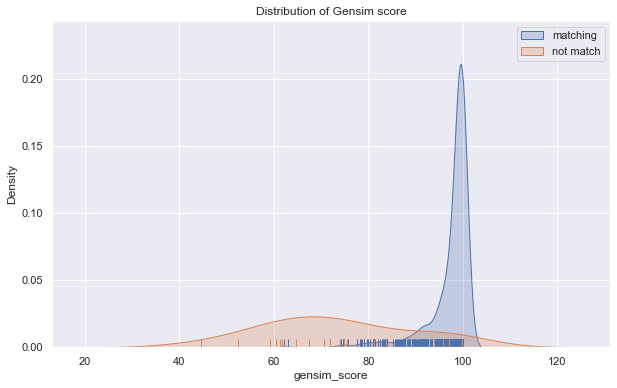

In [31]:
sb.set_theme()
plt.figure(figsize=(10, 6))
sb.distplot(df_match.gensim_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = 'matching')
sb.distplot(df_no.gensim_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "not match")
# sb.distplot(df_top5.gensim_score, label = 'top5_relevance')
plt.legend()
plt.title('Distribution of Gensim score')
plt.show()

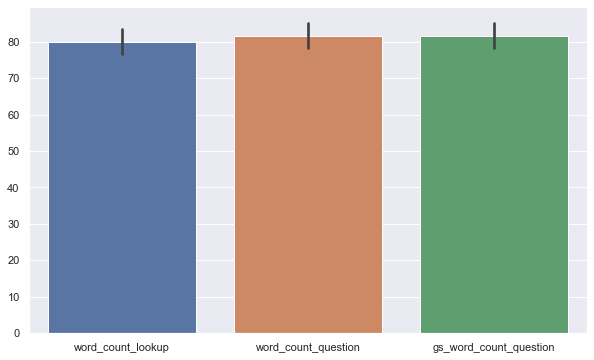

In [32]:
plt.figure(figsize=(10, 6))
sb.barplot(data = df_match[['word_count_lookup', 'word_count_question', 'gs_word_count_question']]);

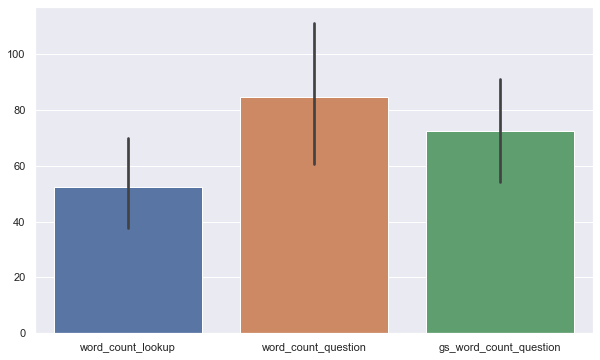

In [33]:
plt.figure(figsize=(10, 6))
sb.barplot(data = df_no[['word_count_lookup', 'word_count_question', 'gs_word_count_question']]);

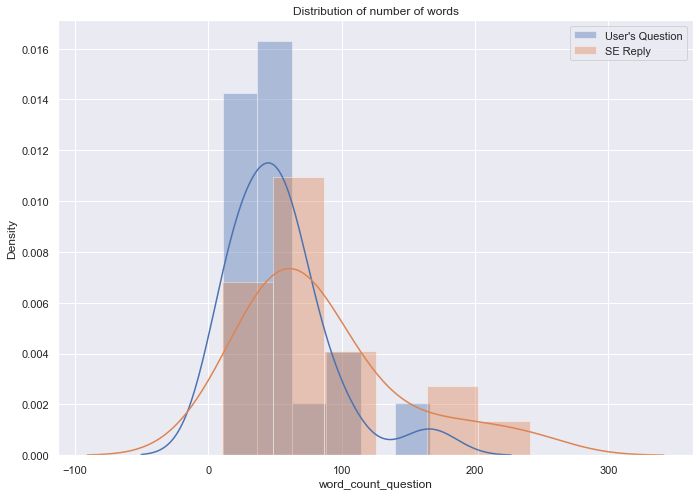

In [34]:
plt.figure(figsize=(25, 8))
plt.subplot(121)
sb.distplot(df_no.word_count_lookup, label = "User's Question")
plt.subplot(121)
sb.distplot(df_no.word_count_question, label = "SE Reply")
plt.legend()
plt.title('Distribution of number of words')
plt.show()

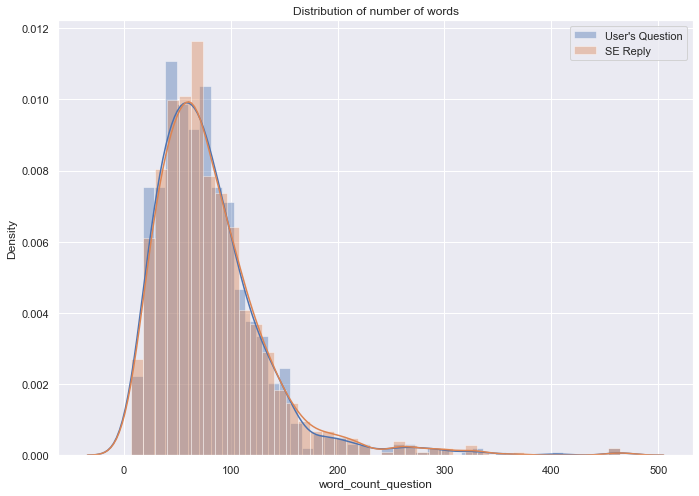

In [35]:
plt.figure(figsize=(25, 8))
plt.subplot(121)
sb.distplot(df_match.word_count_lookup, label = "User's Question")
plt.subplot(121)
sb.distplot(df_match.word_count_question, label = "SE Reply")
plt.legend()
plt.title('Distribution of number of words')
plt.show()

In [36]:
df_no.head()

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question,search_result,gensim_score,gs_word_count_question
20,4533.0,Quan sat hai thanh sau:\na) So 0 có phải la bo...,2. Quan sát hai thanh sau:\n\begin{tabular}{|c...,NEGATIVE,NOT_MATCH,MATCH,https://s3.icankid.io/uploads/question/4d68455...,https://s3.icankid.io/uploads/question/a7ce2dd...,45,quan sat hai thanh sau : a ) so 0 có phải la b...,2 . quan_sát hai thanh sau : \ begin { tabular...,233,61,3.819672,361,105,3.438095,1. Các số \( 4 ; 8 ; 9 ; 16 ; 27 ; 64 ; 81 ; 1...,44.53,195
42,4612.0,Câu \( 2 . \)\na) Tim tập hơp các ước cuaa 30 ...,2. a) Tìm tập hợp các ước của 30 .\nb) Tìm tập...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0de11fb...,https://s3.stag.icankids.com.vn/uploads/questi...,79,câu \ ( 2_._\ ) a ) tim tập hơp các ước cuaa 3...,2 ._a ) tìm tập_hợp các ước của 30 ._b ) tìm t...,98,28,3.500000,189,57,3.315789,1.2. Cho tập hợp\n\[\nU=\{x \in N \mid \underl...,59.25,55
131,5123.0,Cov M Ha tḥp hop các só tư nhiên lón hơn 6 và ...,Luyẹ tạp 3\nGọi \( M \) là tập hợ các số tự nh...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/8a2684f...,https://s3.icankid.io/uploads/question/b89da74...,241,cov m ha tḥp hop các só tư_nhiên lón hơn 6 và ...,luyẹ tạp 3 gọi \ ( m \ ) là tập hợ các số tự_n...,95,24,3.958333,201,68,2.955882,Câu 551. Tìm tất cả các giá trị của tham số \(...,81.28,100
225,5626.0,khi hiem.\na) Khí hiếm náo có điêm đông đạc nh...,1.13. Bảng sau cho biết các điểm đông đặc và đ...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/4be5940...,https://s3.icankid.io/uploads/question/da73543...,434,khi hiem ._a ) khí_hiếm náo có điêm đông đạc n...,1.13 . bảng sau cho biết các điểm đông_đặc và ...,264,61,4.327869,1003,241,4.161826,3. Bảng sau cho biết các điểm đông đặc và điểm...,83.82,71
248,5711.0,"""Yêu nhau cau sáu bổ ba Ghét nhau cau sáu bổ r...","Bài 30\n(Toán cổ) Yêu nhau cau sảu bồ ba,\nGhè...",NEGATIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/4cc3eda...,https://s3.icankid.io/uploads/question/4df1230...,463,""" yêu nhau cau sáu bổ ba ghét nhau cau sáu bổ ...","bài 30 ( toán cổ ) yêu nhau cau sảu bồ ba , gh...",126,32,3.937500,148,39,3.794872,"Ví dụ 2. Sử dụng thuật ngữ ""điều kiện cần"", ""đ...",67.49,58


In [37]:
print(dictionary)

Dictionary<3823 unique tokens: ['(', ')', '-', '0', '0_=_\\_frac']...>


In [38]:
query = df_pos.iloc[0]['Lookup Text']
q = clean_function(query).split()
query_bow = dictionary.doc2bow(q)
query_bow

[(0, 11),
 (1, 17),
 (2, 5),
 (3, 1),
 (5, 5),
 (6, 1),
 (7, 3),
 (8, 1),
 (9, 1),
 (11, 1),
 (12, 2),
 (13, 2),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 15),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 3),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 3),
 (31, 8),
 (32, 16),
 (33, 1),
 (34, 1),
 (35, 4),
 (36, 4),
 (37, 1),
 (38, 2),
 (40, 1),
 (41, 2),
 (46, 1),
 (50, 1),
 (51, 1),
 (411, 1),
 (1231, 1)]

In [39]:
query = df_pos.iloc[0]['Lookup Text']
q = clean_function(query)
q

'đề số \\ ( 1_._\\ ) 1_._tính b ) \\ ( \\ sqrt { 25 }_\\ ) c ) \\ ( \\ sqrt { - 36 }_\\ ) a ) \\ ( \\ sqrt { 64 }_\\ ) e ) \\ ( \\_sqrt { ( - 5 ) ^ { 2 }_}_\\ ) d ) \\ ( \\ sqrt { 5 ^ { 2 }_}_\\ ) f ) \\ ( \\_frac { 2 } { 3_}_\\ sqrt { 81 } - \\_left ( - \\ frac { 3 }_{ 4 }_\\_right ) : \\ sqrt {_\\ frac { 9 }_{ 64 }_}_+_\\_left ( \\ frac {_\\_sqrt { 2 }_}_{_\\ sqrt { 3 }_}_\\_right ) ^_{ 0 } - ( \\ sqrt { 3 } ) ^ { 2 }_\\ )'

In [40]:
q.split()

['đề',
 'số',
 '\\',
 '(',
 '1_._\\',
 ')',
 '1_._tính',
 'b',
 ')',
 '\\',
 '(',
 '\\',
 'sqrt',
 '{',
 '25',
 '}_\\',
 ')',
 'c',
 ')',
 '\\',
 '(',
 '\\',
 'sqrt',
 '{',
 '-',
 '36',
 '}_\\',
 ')',
 'a',
 ')',
 '\\',
 '(',
 '\\',
 'sqrt',
 '{',
 '64',
 '}_\\',
 ')',
 'e',
 ')',
 '\\',
 '(',
 '\\_sqrt',
 '{',
 '(',
 '-',
 '5',
 ')',
 '^',
 '{',
 '2',
 '}_}_\\',
 ')',
 'd',
 ')',
 '\\',
 '(',
 '\\',
 'sqrt',
 '{',
 '5',
 '^',
 '{',
 '2',
 '}_}_\\',
 ')',
 'f',
 ')',
 '\\',
 '(',
 '\\_frac',
 '{',
 '2',
 '}',
 '{',
 '3_}_\\',
 'sqrt',
 '{',
 '81',
 '}',
 '-',
 '\\_left',
 '(',
 '-',
 '\\',
 'frac',
 '{',
 '3',
 '}_{',
 '4',
 '}_\\_right',
 ')',
 ':',
 '\\',
 'sqrt',
 '{_\\',
 'frac',
 '{',
 '9',
 '}_{',
 '64',
 '}_}_+_\\_left',
 '(',
 '\\',
 'frac',
 '{_\\_sqrt',
 '{',
 '2',
 '}_}_{_\\',
 'sqrt',
 '{',
 '3',
 '}_}_\\_right',
 ')',
 '^_{',
 '0',
 '}',
 '-',
 '(',
 '\\',
 'sqrt',
 '{',
 '3',
 '}',
 ')',
 '^',
 '{',
 '2',
 '}_\\',
 ')']

In [41]:
query_tfidf = questions_tfidf_model[query_bow]
query_tfidf

[(0, 0.029374291638985722),
 (1, 0.03479080907781604),
 (2, 0.13436934839932266),
 (3, 0.06153067532564802),
 (5, 0.08445992156551865),
 (6, 0.09309892343143904),
 (7, 0.07994615774698088),
 (8, 0.15694640721232206),
 (9, 0.13005199542618692),
 (11, 0.03666166282033301),
 (12, 0.07453796305966319),
 (13, 0.30739072223316827),
 (14, 0.1805897729027193),
 (15, 0.06596680917512611),
 (16, 0.02081838893253395),
 (17, 0.043959486947236934),
 (18, 0.11727113950496242),
 (19, 0.07674060584765799),
 (20, 0.13884658925535673),
 (21, 0.12347748286998166),
 (22, 0.07453918615041512),
 (23, 0.020070055450766938),
 (24, 0.031633643787986686),
 (25, 0.03286773789527837),
 (26, 0.10881740670644247),
 (27, 0.1034406571852429),
 (28, 0.11180694458949478),
 (31, 0.541332797898727),
 (32, 0.24738157274237535),
 (33, 0.08961017486552332),
 (34, 0.19801411994683177),
 (35, 0.08581916437831813),
 (36, 0.12481398910096309),
 (37, 0.07806543902624594),
 (38, 0.11266409436548254),
 (40, 0.23548796795694857),
 

In [42]:
query_lsi = questions_lsi_model[query_tfidf]
query_lsi

[(0, 0.4850388920159488),
 (1, -0.4422653820374172),
 (2, -0.19651870524186552),
 (3, 0.16928953764906413),
 (4, 0.031153078439221008),
 (5, -0.046852940734833357),
 (6, -0.013741595600875638),
 (7, -0.04843276459873995),
 (8, -0.020567194989670107),
 (9, -0.028434866620025367),
 (10, 0.007589463704402319),
 (11, -0.027187450317354735),
 (12, -0.007328266220831254),
 (13, -0.029505863480371732),
 (14, -0.08122819370391554),
 (15, 0.048182136417722836),
 (16, 0.046343119365189485),
 (17, -0.031841136212578024),
 (18, -0.041317232129849245),
 (19, -0.04284405579996533),
 (20, -0.02027679477464057),
 (21, 0.02843579547008263),
 (22, 0.06658257178157806),
 (23, 0.003030781180099426),
 (24, 0.05874821861842053),
 (25, -0.054358262852757744),
 (26, 0.005922717330466431),
 (27, -0.048858314918829665),
 (28, -0.1097872911975696),
 (29, -0.0033266413829395967),
 (30, -0.0354284515221847),
 (31, 0.06030873653873461),
 (32, -0.0015145036663755211),
 (33, 0.006545800342933615),
 (34, -0.0251896849